# The Latent Space of Podcasts

Nowadays we encounter recommender systems on a daily basis in search engines, streaming platforms, and social media. There exist many different mechanisms behind recommender systems, but we will focus on a a class of methods known as **collaborative filtering**. In a nutshell, this approach consists of taking the set of all known user preferences and using that to "predict" the user's preference for an **item** (movie, song, news article) that the user hasn't seen yet (or for which the user hasn't indicated a preference). The basis for establishing this preference depends on the context. Some examples include user ratings on Netflix, or how many times a user has listened to a song on Spotify.

Collaborative filtering relies on the assumption that similar users will like similar items. Furthermore, similarity is derived solely from the known user preferences, such as ratings, without any knowledge of the content of the items. Note that in practice only a tiny fraction of all user preferences are known. For example, Netflix users will only have watched a small fraction of all available content.

I find **matrix-based** collaborative filtering methods especially interesting. In those methods both the users and the items are represented by vectors in some high-dimensional space, called **latent factors**, which encapsulate both user *preferences* and item *similarity*: Vectors for two similar items (or for a user with a positive preference for an item) point in similar directions.

This latent space reflects patterns or structures in the set of items (for example movie genres), which we can visualize. For this we will need **dimensionality reduction techniques**, such as Principal Component Analysis, or PCA. It is interesting to see which structures emerge just from the set of user preferences, without providing any information about the items or users themselves. It is a useful check for our intuitions in regards to which items are more similar based on concepts like music style or movie genres.

Learning about this made me wonder which patterns the **latent space of podcasts** might reveal, given that I am a big fan of podcasts myself. This has likely already been studied internally by companies such as Apple and Spotify, but I haven't found any publicly available recommender system for podcasts. I imagine that part of the reason is the lack of large open access datasets, which do exist for [movies](https://grouplens.org/datasets/movielens), [music](http://millionsongdataset.com/challenge), and [books](http://www2.informatik.uni-freiburg.de/~cziegler/BX). This is probably because the mainstream appeal of podcasts is a relatively recent phenomenon.

Luckily I was able to find one pretty decent dataset of podcasts reviews on [Kaggle](https://www.kaggle.com/thoughtvector/podcastreviews). It consists of almost a million reviews for over 46,000 podcasts, stored in an SQLite database. Thanks to Stuart Axelbrooke for collecting the reviews and making them available for everyone!

We will use this dataset to create a recommender and visualize the latent factors for some popular podcasts. Before we can do that we will need to clean the data first. The data is a bit more raw than some more mainstream recommeder datasets like MovieLens.

Outline:
- Import from SQLite
- Explore and Clean Data
- Implicit Recommender System
- Latent Factors
- Podcast Similarity
- Discussion
- Closing Thoughts

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import precision_at_k, leave_k_out_split
from scipy import sparse
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Import from SQLite

The whole data is in an SQLite file. The SQLite database contains three tables:
- `podcasts` table containing the podcast ID, name and URL.
- `reviews` table containing all the information associated with every review: the star rating, the review title and content, the date and time it was posted, and finally the author ID of the user who made the review as well as the podcast ID.
- `categories` table, which simply contains a column with podcasts IDs and a column with categories into which to those podcasts have been classified.

We will load the data from the SQLite file into a pandas DataFrame. Specifically, we will take a left join of the podcasts table and reviews table and select a subset of the columns.

For our purposes we will not need the review title and content. However, it would be interesting to do some NLP on the contents as a future project. Maybe some topic modeling which can be combined with collaborative filtering in a hybrid recommender system.

In [2]:
con = sqlite3.connect('data/database.sqlite')

In [3]:
get_ratings = """SELECT author_id AS user_id, p.podcast_id, rating, p.title AS name, created_at
                            FROM podcasts p
                            INNER JOIN reviews r
                            USING(podcast_id)
                            """
ratings_raw = pd.read_sql(get_ratings, con, parse_dates='created_at')

In [4]:
ratings_raw

,user_id,podcast_id,rating,name,created_at
0,F7E5A318989779D,c61aa81c9b929a66f0c1db6cbe5d8548,5,Backstage at Tilles Center,2018-04-24 12:05:16-07:00
1,F6BF5472689BD12,c61aa81c9b929a66f0c1db6cbe5d8548,5,Backstage at Tilles Center,2018-05-09 18:14:32-07:00
2,1AB95B8E6E1309E,ad4f2bf69c72b8db75978423c25f379e,1,TED Talks Daily,2019-06-11 14:53:39-07:00
3,11BB760AA5DEBD1,ad4f2bf69c72b8db75978423c25f379e,5,TED Talks Daily,2018-05-31 13:08:09-07:00
4,D86032C8E57D15A,ad4f2bf69c72b8db75978423c25f379e,5,TED Talks Daily,2019-06-19 13:56:05-07:00
...,...,...,...,...,...
984400,4C3F6BE3495A23D,a23e18c73fd942fab41bcf6b6a1571da,2,Mile Higher Podcast,2021-10-09 07:10:31-07:00
984401,938F0A4490CE344,ae44a724e94dcec1616d6e695e6198ba,4,Something Was Wrong,2021-10-09 16:14:02-07:00
984402,D6CBF74E9B2C7FE,ae44a724e94dcec1616d6e695e6198ba,1,Something Was Wrong,2021-10-09 14:32:49-07:00
984403,FED395AE84679C4,ae44a724e94dcec1616d6e695e6198ba,5,Something Was Wrong,2021-10-09 11:40:29-07:00


Next we create a table of podcasts with some rating statistics: number of ratings, mean rating, and the years of the first and the last rating.

In [5]:
def extract_podcasts(ratings):
    'Get the podcasts with rating count, rating mean and rating years.'
    ratings_copy = ratings.copy()
    return (ratings_copy.groupby('podcast_id', as_index=False)
                       .agg(
                        name = ('name', 'first'),
                        rating_count = ('rating', 'count'),
                        rating_mean = ('rating', 'mean'),
                        earliest_rating_year = ('created_at', lambda c: c.min().year),
                        latest_rating_year = ('created_at', lambda c: c.max().year),
                       )
           )

In [6]:
podcasts_raw = extract_podcasts(ratings_raw)
podcasts_raw

,podcast_id,name,rating_count,rating_mean,earliest_rating_year,latest_rating_year
0,a00018b54eb342567c94dacfb2a3e504,Scaling Global,1,5.000000,2017,2017
1,a00043d34e734b09246d17dc5d56f63c,Cornerstone Baptist Church of Orlando,1,5.000000,2019,2019
2,a0004b1ef445af9dc84dad1e7821b1e3,Mystery: Dancing in the Dark,1,1.000000,2011,2011
3,a00071f9aaae9ac725c3a586701abf4d,KTs Money Matters,4,5.000000,2018,2018
4,a000aa69852b276565c4f5eb9cdd999b,Speedway Soccer,15,5.000000,2018,2020
...,...,...,...,...,...,...
46688,fffe3f208a56dfecfaf6d0a7f8399d63,How Travel Writers Self-Publish,4,5.000000,2019,2020
46689,fffeb7d6d05f2b4c600fbebc828ca656,TEDDY & THE EMPRESS: Cooking the Queens,43,4.837209,2017,2021
46690,ffff5db4b5db2d860c49749e5de8a36d,"Frankenstein, or the Modern Prometheus",8,4.750000,2011,2021
46691,ffff66f98c1adfc8d0d6c41bb8facfd0,Who’s Bringing Wine?,5,5.000000,2018,2018


## Data Exploration and Cleaning

In this section we will deal with some issues in the data and prepare it for the recommender system below.

### How far back do the reviews go?

A couple of ratings go all the way back to 2005 although most of them only go back to 2018. For many popular podcasts the reviews start in 2019.

When I asked the curator of the dataset on Kaggle why the reviews go much further back for some podcasts than for most others, he clarified that the reason is that the Apple API only gives access the latest 500 reviews of each podcast. This explains why for popular podcasts those 500 reviews only go back a couple of months, but for others they go back many years.

Inspecting the dates of the reviews of some popular podcasts, I found no gaps since 2019. This confirms that the reviews have been downloaded without interruption since then.

### Curating the Ratings

We need to take care of the following complications:
- Some users have left a suspiciously high number of reviews. Indeed, looking at the content of their reviews they do not look genuine at all: they repeat the same text hundreds of times, with slight variations. We will remove all the users with a rating volume beyond a specific threshold to weed out bots. We set the threshold at 135 reviews by inspecting the content of the reviews and making a judgment call.
- It appears that some podcasts are no longer active, given that their latest review was made years ago. We need to decide whether we want to remove these seemingly inactive podcasts. While we don't want to recommend podcasts that don't exist anymore, their reviews can still help the collaborative filtering model. We will simply remove podcasts which have zero reviews made on or after 2020. Another option would be to include old podcasts in the training of the recommender system but skip them when making recommendations.
- It turns out that there are repeat reviews in the data, meaning that some users left multiple reviews for the same podcast. They are probably just edited or updated reviews. Consequently, we will only consider the latest rating for each user-podcast pairing.
- For the collaborative filtering approach to work, the users need to have rated multiple podcasts and, similarly, the podcasts need to have been rated by multiple users. To ensure this, we need to remove all users and podcasts with a number of reviews below a certain threshold. For example, we could remove all users with under 3 reviews and all podcasts with under 15 reviews. We have to be careful here: removing some users will reduce the number of reviews for some podcasts, which might push some podcasts below the threshold. In turn, removing those podcasts might push some users below the threshold. We need to keep doing this back and forth until the ratings DataFrame stops changing.

We will write a separate function to deal with each point.

In [7]:
def remove_suspicious_users(ratings, max_reviews=135):
    'Remove users with suspiciously high review count.'
    mask = ratings.groupby('user_id')['podcast_id'].transform('count') <= max_reviews
    return ratings[mask]

def remove_inactive_podcasts(ratings, latest_rating_year=2020):
    'Remove podcasts with no reviews at or after latest_rating_year.'
    active = (ratings.groupby('podcast_id')['created_at']
                     .transform(lambda c: c.max().year)
                    >= latest_rating_year
               )
    return ratings[active]

def keep_only_latest_rating(ratings):
    'Remove repeat reviews, keeping the latest. Also sorts the ratings by date.'
    return ratings.sort_values(by='created_at', ascending=False).drop_duplicates(subset=['podcast_id', 'user_id'])
    
def remove_low_rating_users_and_podcasts(ratings, min_user_reviews=3, min_podcast_reviews=15):
    'Alternate between removing podcasts and users with insufficient reviews until there are none left.'
    result = ratings.copy()
    while result.shape:
        previous_shape = result.shape
        mask = result.groupby('podcast_id')['user_id'].transform('count') >= min_podcast_reviews
        result = result[mask]
        mask = result.groupby('user_id')['podcast_id'].transform('count') >= min_user_reviews
        result = result[mask]
        if result.shape == previous_shape:
            return result

In [8]:
ratings = remove_suspicious_users(ratings_raw)
ratings = remove_inactive_podcasts(ratings)
ratings = keep_only_latest_rating(ratings)
ratings = remove_low_rating_users_and_podcasts(ratings)

In [9]:
ratings

,user_id,podcast_id,rating,name,created_at
984386,2ED4C4FD5F1740E,a9bdaba5449189a4587793e36ce4f704,5,Going West: True Crime,2021-10-09 16:24:40-07:00
984402,D6CBF74E9B2C7FE,ae44a724e94dcec1616d6e695e6198ba,1,Something Was Wrong,2021-10-09 14:32:49-07:00
984376,C0E30B0BB0AA10C,ddd451a18055f0108edf79f8c3c9bf15,5,What If World - Stories for Kids,2021-10-09 07:36:51-07:00
984301,E220A79CBD5C5AD,b9a8d90ae43232769ecc68d7defb0c38,5,Scared To Death,2021-10-09 03:51:32-07:00
984316,36B07D3E02D2516,c3f080cc393035a81d4ac7c7bff1c6c1,5,Smash Boom Best,2021-10-09 03:45:35-07:00
...,...,...,...,...,...
138992,4A06D17875D08A3,fb3a6b9f12f4d0b050887e91684e68c0,5,EconTalk,2007-04-21 20:49:49-07:00
50962,4A06D17875D08A3,d2f31ced463510866c6adfbae95d3be2,2,Money Girl's Quick and Dirty Tips for a Richer...,2007-03-31 21:09:12-07:00
479293,245BC52E7C82EA7,b913c95d304bac8b6cddf9034294eab7,5,PotterCast: The Harry Potter podcast since 2005,2006-10-18 14:14:46-07:00
479291,39D9B7796AA0A6C,b913c95d304bac8b6cddf9034294eab7,5,PotterCast: The Harry Potter podcast since 2005,2006-05-20 11:18:27-07:00


In [10]:
podcasts = extract_podcasts(ratings)

In [11]:
podcasts.sort_values(by='rating_count', ascending=False)

,podcast_id,name,rating_count,rating_mean,earliest_rating_year,latest_rating_year
245,bc5ddad3898e0973eb541577d1df8004,My Favorite Murder with Karen Kilgariff and Ge...,688,3.228198,2019,2021
228,bad6c91efdbee814db985c7a65199604,Wow in the World,649,4.648690,2019,2021
807,f2377a9b0d9a2e0fb05c3dad55759328,Story Pirates,589,4.590832,2016,2021
334,c3f080cc393035a81d4ac7c7bff1c6c1,Smash Boom Best,470,4.740426,2018,2021
142,b1a3eb2aa8e82ecbe9c91ed9a963c362,True Crime Obsessed,434,3.679724,2019,2021
...,...,...,...,...,...,...
821,f3c3640687112903a1fa5869665682ae,American Ball Tales,15,4.933333,2019,2020
301,c0f3a638b96dd2482255211827f1a95a,Dreams In Drive,15,5.000000,2016,2021
306,c149f512e2e103090a77b32d42511479,Cantina Cast,15,4.400000,2013,2019
202,b76c794eb4bb5b73748bd8e5dc8052b8,Congeria,15,4.200000,2018,2020


Out of the 46,693 podcasts we started with, we are left with 936. Unfortunately, it is inevitable that we have to discard a large fraction of the podcasts because most of them have only a few reviews on Apple Podcasts. Consider the fact that more than a fourth of the podcasts (13,922 to  be  precise) had only a *single review*. More that half of the podcasts (a total of 25,104) had only up to 3 reviews!

That said, it's worth noting that there are actually as many as 8323 podcasts with at least 15 ratings. However, a sizable portion of the users leaving those ratings had to be removed because they only rated one or two podcasts in total (and of course removing some podcasts led to having to remove more users and so on). Thus, this is how we are left with just 936 podcasts.

The remaining ratings are still sufficient to yield interesting results, though!

The minimum threshold of ratings for users and podcasts is also reflected in the **density of the ratings matrix**. The so called *ratings matrix* contains all the ratings such that each row corresponds to one user and each column corresponds to one podcast. If there is a particular user hasn't rated a particular podcast, the corresponding entry (where the user row and podcast column meet) is simply $0$. Furthermore, the *density* of the ratings matrix is the percentage of non-zero entries. In other words, the density is the percentage of user-podcast pairs for which a rating exists in the dataset.

In [12]:
def compute_density(ratings):
    n_ratings = ratings.shape[0]
    n_podcasts = ratings['podcast_id'].nunique()
    n_users = ratings['user_id'].nunique()
    return n_ratings / (n_podcasts * n_users)

In [13]:
print(f'The density of the curated rating matrix is {compute_density(ratings) * 100:.2f}%, while the density of the original rating matrix is {compute_density(ratings_raw) * 100:.4f}%.')

The density of the curated rating matrix is 0.45%, while the density of the original rating matrix is 0.0028%.


We went from 755,438 users to 12,212 users after cleaning up the data and discarding users and podcasts with too few reviews.

Unfortunately, the vast majority of users left only a single review (in this dataset at least). This is probably at least partly due to the fact that many popular podcasts are missing and even for those included the reviews go back only three years. However, even taking this into account, it is conceivable that most people listen to fewer podcasts than Netflix users watch different shows and movies, for example. There is also more friction (more time and steps involved) for leaving a review on Apple Podcasts than rating a show on Netflix, again as an example.

## Implicit Recommender System

It turns out that the overwhelming majority of the ratings are 5 star ratings. It appears that most users do not go out of their way to give a negative rating unless they really dislike a show  The following bar chart shows the frequency of each star rating in the curated ratings table. The situation is even more skewed in favor of 5 star ratings in the raw ratings data.

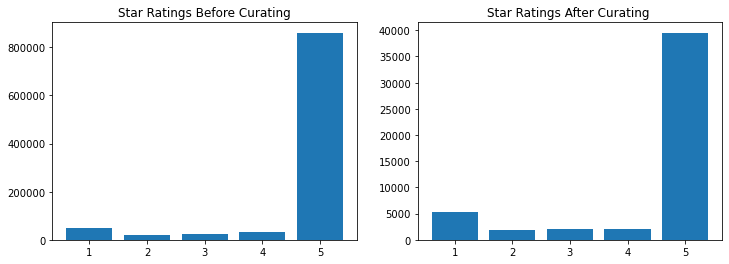

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

ax0.set_title('Star Ratings Before Curating')
ax0.bar(ratings_raw['rating'].value_counts().index, ratings_raw['rating'].value_counts().values)
ax1.set_title('Star Ratings After Curating ')
ax1.bar(ratings['rating'].value_counts().index, ratings['rating'].value_counts().values);

### Why Implicit?

When I started this project I intended to use a model which tries to predict the *specific star rating* a user would give to "unseen" items, in order to recommend the item with the highest predicted rating. This is how **explicit recommender systems** work, which are trained on *explicit* user feedback (in this case, star ratings). However, the extreme imbalance in the ratings suggests that the explicit recommender system approach might not be appropriate here.

First of all, there is a well-known issue with imbalanced data which can be illustrated as follows. The simple baseline model which predicts that every user will rate every podcast with 5 stars would have a high accuracy, because it would be right almost all of the time. That said, this is not a big deal and can be corrected by choosing a more appropriate metric than plain accuracy.

The deeper concern in this case is the **reason behind the class imbalance**. It appears that that most users simply stop listening to a podcast they don't like without bothering to leave a negative review. Not only that, but people clearly don't just pick podcasts at random to listen to. Instead, there is a pre-selection: they follow a friend's recommendation, seek out podcasts on a particular topic or featuring a particular guest, and so on. Needless to say, users are unlikely to leave a review for a podcast they never listened to (although I am sure that a handful of people do).

All of this is to say:
- In explicit recommender systems missing ratings are viewed simply as missing information. However, it appears that there actually *is* some information given by the fact that a podcast wasn't rated by a user. Maybe we should think of missing ratings as suggesting a *negative preference*, but assigning *low confidence* to that preference. Some reasons why a missing rating potentially reveals a negative preference were given above. Namely, users are less likely to rate a podcast they don't like and many are even unlikely to listen to it in the first place. On the other hand, the confidence in this negative preference is low because the rating might be missing for a variety of other reasons. The most likely reason is that the user isn't even aware of that particular podcast's existence.
- Focusing mostly on the precise ratings (1 to 5 stars) is of limited value because users seem to be using the stars mostly to give a "thumbs up" (5 stars).

It turns out that there is an approach which seems to be perfectly suited to address the two issues above: **implicit recommender systems**. They are called implicit because they usually do not use (explicit) feedback given by the users. Instead they infer the preferences of users from their activity, such as how often a user has listened to a song on Spotify, or if a user has watched the entirety of a movie on Netflix. The fundamental change from explicit to implicit systems is that instead of giving *ratings*, users have *preferences* and those preferences are known to us with a certain *confidence*. What this allows us to do is to interpret the absence of activity (user didn't watch a particular movie) as a negative preference, but with low confidence.

Unfortunately, we don't have access to user activity, but the ratings (which are explicit feedback) can be made "implicit" with the following interpretation: high ratings (4 or 5 stars) correspond to positive preferences with high confidence, while missing ratings and all lower ratings (1 to 3 stars) correspond to negative preferences with low confidence. It is possible to treat low ratings separately from missing ratings but this doesn't seem to improve the results, maybe due to the low frequency of low ratings.

### Alternating Least Squares

We will use the `implicit`, a very fast recommender library written in Cython by Ben Frederickson. Specifically, we will use the **Alternating Least Squares** algorithm, or ALS. The ALS algorithm for implicit recommenders was introduced in [this paper](http://yifanhu.net/PUB/cf.pdf) by Hu, Koren and Volinsky. I will not go into too much detail here, but a general explanation is outlined below. In addition to the original paper, I recommend reading [this](https://jessesw.com/Rec-System/) blog post, in which the algorithm is implemented in Python (although the implicit library is actually used for speed).

Here is a brief overview of the model we will use: Each user $u$ is assumed to have a **preference** $p_{ui}$ for podcast $i$ and we want to find **latent factors** $x_u$ and $y_i$ such that their inner product approximates the preference: $p_{ui} \approx x_u\cdot y_i$. More precisely, we want to find $x_u$ and $y_i$ which minimize the following cost function:
$$
\sum_{u,i} c_{ui}(p_{ui} - x_u\cdot y_i)^2 + \lambda \left(\sum_u \|x_u\|^2 + \sum_i \|y_i\|^2\right)
$$

The weights $c_{ui}$ are the **confidence** that we have in the respective preference $p_{ui}$. The higher the confidence, the more importance we give to approximating the particular preference $p_{ui}$ by $x_u\cdot y_i$. The summands multiplied by $\lambda$ are there to avoid overfitting.

If we hold constant the user vectors $x_u$, the cost function is quadratic in the podcast vectors $y_i$ and can be minimized efficiently. The same is true swapping $x_u$ and $y_i$. This where the Alternating Least Squares trick comes in: First compute the $y_i$ which minimize the cost function with $x_u$ held constant. Then fix $y_i$ at that (provisional) minimum and in turn find $x_u$ minimizing the resulting cost function. Amazingly, simply doing this back and forth several times yields pretty good results. 

### The Implicit Matrix

In order to feed our data to the implicit ALS model, we need to transform our table of explicit ratings into a matrix of implicit data. The entries of the matrix need to incorporate both the confidence factors $c_{ui}$ and the preference factors $p_{ui}$.

In order to construct the matrix correctly, we need to know which input the model `implicit.AlternatingLeastSquares` expects. We feed the ALS model a single matrix, which then (internally) deduces preferences and confidence from that single matrix. If there is a positive entry at a position $(u,i)$, this is taken to mean that $p_{ui} = 1$ (positive preference), otherwise $p_{ui} = 0$ (negative entries). The precise values of the entries are also important: The element at position $(u,i)$ equals the confidence $c_{ui}$, after adding 1 to make sure that the confidence is at least 1 for all $(u,i)$ (if the confidence at some point were 0 the preference $p_{ui}$ would be irrelevant in the cost function, which we want to avoid in the implicit setting). 

In light of the above, it's clear that our implicit matrix needs strictly positive entries for each pair $(u,i)$ for which the user $u$ gave the podcast $i$ a high ratings, and all other entries should be set to 0. Marking low ratings (1 or 2 stars, say) with negative entries in the matrix did not help much when I tried it, so we will avoid this. (That would mean a higher confidence in the negative preference for low ratings, as opposed to missing ratings.)

Here is what we will do: The implicit matrix will have a 1 at every position corresponding to a high rating (4 or 5 stars) and a 0 everywhere else. There is nothing special about the value 1, which can be changed later to any other number (by simply multiplying the matrix by that number). Note that most entries are 0, given that most users have not left reviews for most podcasts. In other words, the matrix will have a **high sparsity** (low density). This is why it makes sense to use a `scipy` sparse matrix instead of a NumPy array.

In [15]:
def make_implicit(ratings, threshold=4):
    '''Replace star rating (1 to 5) by a +1 if rating >= threshold
    and if rating < threshold either replace it by a -1 (if negative is True)
    or remove it (if negative is False).
    Return a csr sparse matrix with the ratings (users rows and podcasts cols)
    and two lists: one with the user_ids corresponding to the rows and
    one with the podcast names corresponding to the columns.
    '''
    positive = ratings['rating'] >= threshold
    implicit_ratings = ratings.loc[positive].copy()
    implicit_ratings['rating'] = 1
    
    # Remove low rating users and podcasts again
    implicit_ratings = remove_low_rating_users_and_podcasts(implicit_ratings, 2, 5)
    
    user_idx = implicit_ratings['user_id'].astype('category').cat.codes
    podcast_idx = implicit_ratings['podcast_id'].astype('category').cat.codes
    # The codes simply number the user_id and podcast_id in alphabetical order
    # We keep track of the order of the users and podcasts with the following arrays
    user_ids = implicit_ratings['user_id'].sort_values().unique()
    podcast_names = implicit_ratings.sort_values(by='podcast_id')['name'].unique()
    
    implicit_ratings = sparse.csr_matrix((implicit_ratings['rating'], (user_idx, podcast_idx)))
    return implicit_ratings, user_ids, podcast_names
    

In [16]:
implicit_ratings, user_ids, podcast_names = make_implicit(ratings)
implicit_ratings.shape

(10607, 933)

### Training and Evaluation

At last, we are ready to train our recommender!

To evaluate the performance of a recommender we need to be able to decide if recommendations are relevant. However, if the system simply recommends podcasts that it already "knows" the user likes (positive entry in the implicit matrix), this doesn't reflect how well the system can make recommendations for podcasts the user hasn't shown a preference for yet (0 in the implicit matrix).

To address this, we will turn one positive entry into a 0 entry for each user. In other words, for each user we will forget one podcast the user rated highly. Then we train the recommender system on this modified implicit dataset (called the **training set**). Next, we let the model make one recommendation per user, but require that for each user the podcast recommended has not already been "liked" by that user in the training set. Finally, we compute the **precision** of the recommender: the fraction of the users for which the recommendation is precisely the podcast we "forgot" for that user when creating the training set. Recall that we know those "forgotten" podcasts to be relevant recommendations, because the user gave them a high rating (which we omitted in the training set).

Note that recommendations other than the one positive preference we omitted (for each user) might also be relevant, but there is no way for us to verify that with our data. In light of this, the precision might in fact underestimate how often the recommendations are relevant.

The (simple) precision is not the best metric. For example, it would be better to omit several ratings for each user and then compute the **precision at k (denoted p@k)**, which consists of recommending $k$ podcasts for each user and determining which fraction of those recommendations is relevant. What we are doing above is effectively p@1 (precision at 1). There are other more sophisticated metrics, but they also require making multiple recommendations per user. The reason we cannot use these metrics is that most users only have 3 ratings and removing more than one would leave them with 1 rating, which is basically useless for collaborative filtering. If we instead only removed ratings from a subset of users who left many ratings, we would be biasing our metric in favor of a minority of very active users.

In [17]:
ratings_train, ratings_test = leave_k_out_split(implicit_ratings, K=1)

In [18]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
als_recommender = AlternatingLeastSquares(factors=50, regularization=0.1, random_state=42)
als_recommender.fit(2 * ratings_train.T)

  0%|          | 0/15 [00:00<?, ?it/s]

In [19]:
precision_at_k(als_recommender, ratings_train, ratings_test, K=1)

  0%|          | 0/10607 [00:00<?, ?it/s]

0.09263038548752835

As a baseline, we will also compute the precision for a simple recommender which recommends the most popular podcast to all users. To be precise, it recommends the most popular podcast among those not already liked by the user in the training set, because those recommendations are not scored as hits when computing the precision (we want the recommender to suggest "new" podcasts after all).

We write the baseline in such a way that it can also recommend multiple podcasts. It simply recommends the $N$ most popular podcasts, given some $N$.

In [20]:
class PopularityBaseline():
    def __init__(self, implicit_ratings):
        podcast_ids, count = np.unique(implicit_ratings.tocoo().col, return_counts=True)
        self.top_podcasts = podcast_ids[np.argsort(-count)]
    def recommend(self, user_id, user_items, N=10):
        '''Recommend the most popular podcasts, but exclude podcasts which the users in user_ids
        have already interacted with according to user_items'''
        user_items = user_items.tocoo()
        this_user = user_items.row == user_id
        liked_podcasts = set(user_items.col[this_user])
        recom = []
        for podcast in self.top_podcasts:
            if podcast not in liked_podcasts:
                recom.append(podcast)
            if len(recom) == N:
                break
        else:
            raise Exception('Not enough podcasts remaining to recommend')
        return list(zip(recom, [0] * N)) # The implicit API expects a score for each podcast
        
popularity_baseline = PopularityBaseline(implicit_ratings)

In [21]:
precision_at_k(popularity_baseline, ratings_train, ratings_test, K=1)

  0%|          | 0/10607 [00:00<?, ?it/s]

0.02913832199546485

Our recommender system is significantly better than the baseline recommender ($9.3\%$ versus $2.9\%$). It appears the recommender learned something!

Now we will train the recommender again but with the whole implicit rating set, not just the a smaller training set. We will use this recommender going forward.

In [22]:
als_recommender = AlternatingLeastSquares(factors=50, regularization=0.1, random_state=42)
als_recommender.fit(2 * implicit_ratings.T)

  0%|          | 0/15 [00:00<?, ?it/s]

## Latent Factors

Recall that the our recommender works by finding latent factors for all podcasts and all users, such that the inner product of the user and podcast vectors is as close as possible to the corresponding user preferences. Another way of looking at this is that preference (of a user for a podcast) or similarity (of two podcasts, or two users, to each other) corresponds to vectors pointing in a similar direction (technically, having a high cosine similarity, or low cosine distance).

In light of the above, to introspect the recommender we must visualize the latent factors. We will do this for the most popular podcasts in the dataset. Because the latent space is 50-dimensional we will project it down to 2 dimensions. We will use **Principal Component Analysis** (PCA) to find the two directions in which the latent factors vary the most and project down to those.

In [23]:
podcast_ids, count = np.unique(implicit_ratings.tocoo().col, return_counts=True)
top_podcasts = podcast_ids[np.argsort(-count)][:25]

In [24]:
pca = PCA(n_components=5)
reduced_item_factors = pca.fit_transform(als_recommender.item_factors)

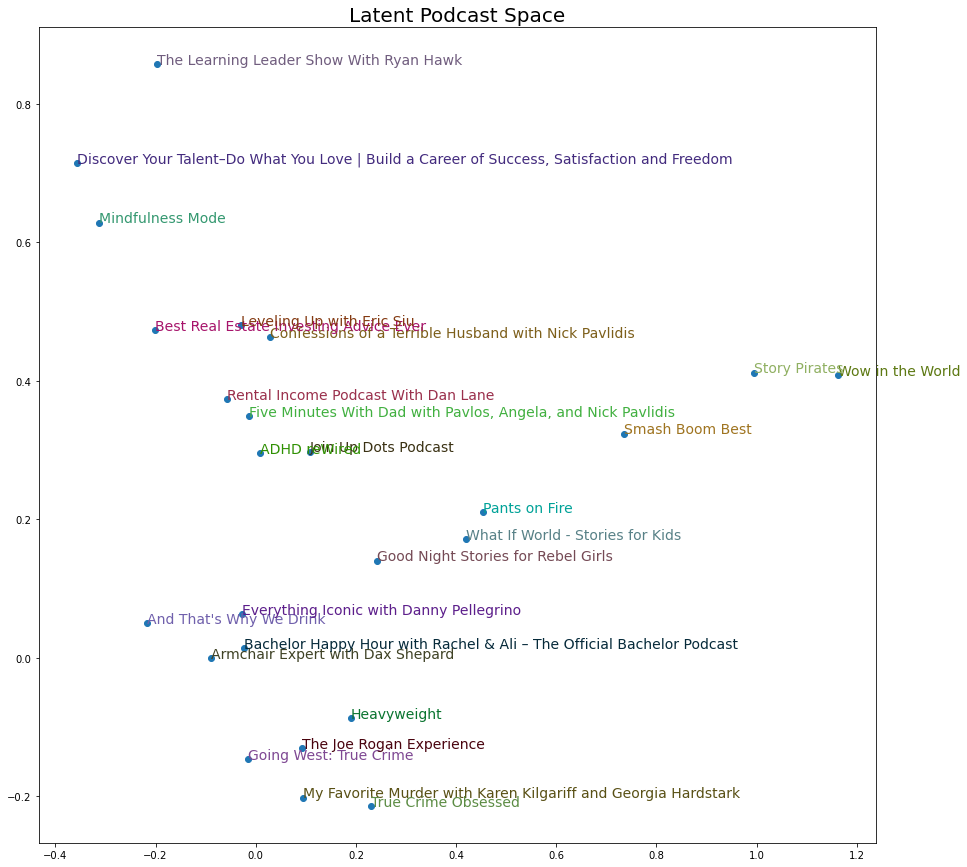

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))

X = reduced_item_factors[top_podcasts].T[1]
Y = reduced_item_factors[top_podcasts].T[0]
ax.set_title('Latent Podcast Space', fontdict = {'fontsize' : 20})
ax.scatter(X, Y)
for i, x, y in zip(podcast_names[top_podcasts], X, Y):
    ax.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=14)

We must take the visualization with a grain of salt because obviously information is lost when we project a 50-dimensional space down to two dimensions. Specifically, podcasts that appear close in the projection might not be close at all in the full space.

That said, there appears to be some clear structure, which we will describe below. We must also remember that this is not some random 2D projection, but a projection to the two axes of highest variability (principal components).

Let's start with the **horizontal direction** (or x axis). Podcasts targeted at children are on the right and podcasts targeted at more mature audiences are to the left. The most extreme values are attained by 'Wow to the World' and 'Story Pirates', which are the most popular podcasts for kids. Judging from the content of the reviews there seems to be a bit of a rivalry between those two podcasts, although they have a large overlap in preference. 'Smash Boom Best' and 'Pants on Fire' are for children as well. It is interesting that the two podcasts on stories for kids are so close to each other.

In the **vertical direction** (or y axis), the situation is not as clear-cut but we can recognize different genres bunch together.  The podcasts at the top all focus on self-improvement or self-help. The tiles 'The Learning Leader Show', 'Discover Your Talent', and 'Mindulness Mode' are self-explanatory. 'Confessions of a Terrible Husband' is about relationship advice. As for 'Leveling Up', this is a (partial) quote from the official website: "Leveling Up is a radical new perspective on achieving success \[...\]". On the other hand the podcasts at the bottom are all for pure entertainment (true crime themed and slightly above, pop culture and comedy).

## Podcast Similarity

As a reality check, we will go through a couple of popular podcasts and inspect the 10 most similar podcasts according to our model. I find the results pretty impressive considering the limited information the model was trained on. Click on "show" to view the output.

In [26]:
def get_k_most_similar_podcasts(name, recommender, podcast_names, K=10):
    this_name = np.where(podcast_names == name)[0][0]
    return [podcast_names[idx] for idx, _ in recommender.similar_items(this_name, N=K+1)[1:]]

In [27]:
#collapse-output
get_k_most_similar_podcasts('My Favorite Murder with Karen Kilgariff and Georgia Hardstark', als_recommender, podcast_names, 10)

['Scary Stories To Tell On The Pod',
 'Puck Soup',
 'Who Killed Theresa?',
 'Murder Minute',
 'Mother, May I Sleep With Podcast?',
 'Manifestation Babe',
 'Encyclopedia Womannica',
 'Highest Self Podcast',
 'The TryPod',
 'Story Story Podcast: Stories and fairy tales for families, parents, kids and beautiful nerds.']

In [28]:
#collapse-output
get_k_most_similar_podcasts('The Joe Rogan Experience', als_recommender, podcast_names, 10)

['Bret Weinstein | DarkHorse Podcast',
 'Artificial Intelligence (AI)',
 'Cleared Hot',
 'Ben Greenfield Fitness',
 'The Bill Bert Podcast',
 'Walk-Ins Welcome w/ Bridget Phetasy',
 "Congratulations with Chris D'Elia",
 'Jocko Podcast',
 'expediTIously with Tip "T.I." Harris',
 'Team Never Quit']

In [29]:
#collapse-output
get_k_most_similar_podcasts('Story Pirates', als_recommender, podcast_names, 10)

['By Kids, For Kids Story Time',
 'Katie, The Ordinary Witch',
 'Listen Out Loud with The Loud House',
 'Minecraft Me - SD Video',
 'Story Story Podcast: Stories and fairy tales for families, parents, kids and beautiful nerds.',
 'Scary Story Podcast',
 'Wow in the World',
 'Highlights Hangout',
 'The Casagrandes Familia Sounds',
 'KiDNuZ']

In [30]:
#collapse-output
get_k_most_similar_podcasts('Best Real Estate Investing Advice Ever', als_recommender, podcast_names, 10)

['Real Estate Investing For Cash Flow Hosted by Kevin Bupp.',
 'Jake and Gino: Multifamily Real Estate Investing & More',
 'Target Market Insights: Multifamily + Marketing',
 'Before the Millions | Lifestyle Design Through Real Estate | Passive Cashflow Investing Tips and Str...',
 'Lifetime Cash Flow Through Real Estate Investing',
 'Dwellynn Show - Financial Freedom through Real Estate Investing',
 'Investing In The U.S.',
 'Accelerated Investor Podcast',
 'Support is Sexy Podcast with Elayne Fluker | Interviews with Successful Women Entrepreneurs 5 Days a...',
 'Simple Passive Cashflow']

In [31]:
#collapse-output
get_k_most_similar_podcasts('Mindfulness Mode', als_recommender, podcast_names, 10)

['Pregnancy Podcast',
 'The Bitcoin Knowledge Podcast',
 'Undone Redone',
 'Recording Studio Rockstars',
 'Take Up Code',
 'Wedding Planning Podcast',
 'Podcast Junkies',
 'Tandem Nomads - From expat partners to global entrepreneurs!  Build a successful business and thrive...',
 'Fearless And Healthy Podcast|Holistic Health|Success Habits|Lifestyle',
 'Play Your Position with Mary Lou Kayser']

In [32]:
#collapse-output
get_k_most_similar_podcasts('ADHD reWired', als_recommender, podcast_names, 10)

['People Behind the Science Podcast - Stories from Scientists about Science, Life, Research, and Scien...',
 'Brilliant Business Moms with Beth Anne Schwamberger',
 'The Inside Winemaking Podcast with Jim Duane',
 'Top Traders Unplugged',
 'Big Wig Nation with Darrin Bentley',
 'Own It! For Entrepreneurs.  Talking Digital Marketing, Small Business, Being Digital Nomads and Succ...',
 'Maura Sweeney: Living Happy Inside Out | Encouragement | Inspiration | Empowerment | Leadership',
 'Commercial Real Estate Elite: Broker to Brokers',
 'Whistle and a Clipboard- the coaching communities resource',
 'Podcast Junkies']

In [33]:
#collapse-output
get_k_most_similar_podcasts('Good Night Stories for Rebel Girls', als_recommender, podcast_names, 10)

['Fierce Girls',
 'Short & Curly',
 'Big Life Kids Podcast',
 'Dream Big Podcast',
 'Book Club for Kids',
 'Katie, The Ordinary Witch',
 'Saturday Morning Theatre',
 'KiDNuZ',
 'Storynory - Stories for Kids',
 'The Calm Kids Podcast']

In [34]:
#collapse-output
get_k_most_similar_podcasts('Leveling Up with Eric Siu', als_recommender, podcast_names, 10)

['Leaders Inspire Leaders | Koy McDermott - Millennial Leadership Consultant | Personal & Professional...',
 "Where There's Smoke",
 'Tandem Nomads - From expat partners to global entrepreneurs!  Build a successful business and thrive...',
 'On Air with Ella',
 'Everyday MBA',
 'MLM Nation',
 "Worldbuilder's Anvil",
 'The Bitcoin Knowledge Podcast',
 'Fearless And Healthy Podcast|Holistic Health|Success Habits|Lifestyle',
 'Play Your Position with Mary Lou Kayser']

In [35]:
#collapse-output
get_k_most_similar_podcasts('Pants on Fire', als_recommender, podcast_names, 10)

['The Mayan Crystal',
 'The Cramazingly Incredifun Sugarcrash Kids Podcast',
 'Minecraft Me - SD Video',
 'Saturday Morning Theatre',
 'Short & Curly',
 'Smash Boom Best',
 'Book Club for Kids',
 'The Casagrandes Familia Sounds',
 'The Past and The Curious: A History Podcast for Kids and Families',
 'Listen Out Loud with The Loud House']

In [36]:
#collapse-output
get_k_most_similar_podcasts('Bachelor Happy Hour with Rachel & Ali – The Official Bachelor Podcast', als_recommender, podcast_names, 10)#collapse-output

['Logically Irrational',
 'Mommies Tell All',
 'The Ben and Ashley I Almost Famous Podcast',
 'Hot Marriage. Cool Parents.',
 'Miraculous Mamas',
 'Off The Vine with Kaitlyn Bristowe',
 'Scrubbing In with Becca Tilley & Tanya Rad',
 'Ringer Dish',
 'Know Your Aura with Mystic Michaela',
 'Another Bachelor Podcast']

In [37]:
#collapse-output
get_k_most_similar_podcasts("And That's Why We Drink", als_recommender, podcast_names, 10)

['Two Girls One Ghost',
 "Dude, That's F****d Up",
 'Wine & Crime',
 'Ghost Town',
 'I Said God Damn! A True Crime Podcast',
 'Beyond the Secret',
 'Cult Podcast',
 'Potterless',
 'Death in the Afternoon',
 'The Alarmist']

## Discussion
Despite the fact that the dataset was drastically reduced after curation (removing podcasts with insufficient reviews and so on), the recommender still has 933 podcasts and about 10,607 users to work with, with a total of 40,585 positive ratings. The density is around $0.4\%$, meaning that around $0.4\%$ of all possible ratings (in other words, out of all user-podcast pairs) are are actually realized in the data.

While this is a relatively small dataset for collaborative filtering, our recommender did pretty well:
- On our test set, the accuracy was $0.09$ which is three times as high as the baseline recommender (which simply recommends the most popular podcasts). Recall that we computed this number by training the recommender while omitting 1 rating per user and then checking how often the omitted podcast was the *first* recommendation for each user. Getting the single omitted podcast on the first recommendation for $9\%$ of users seems pretty good.
- When we looked at recommendations of individual podcasts they were very compelling.
- Finally, as we described above, there are clear patterns in the latent factors of the podcasts which can be visualized with PCA. We can summarize those findings as follows: The first principal component seems to correspond to a spectrum going from self-improvement to pure entertainment (with true crime at the very end). Along the second principal component the podcasts separate according to whether they are targeted at kids or adults.

## Closing Thoughts

It seems that it was a good choice to turn the star ratings into an **implicit** dataset, with preferences and confidences. Remember that we did this because the vast majority of ratings give 5 stars, which suggests that a lot of information lies in the podcasts a user did *not* rate. That information is lost in the explicit paradigm because missing ratings are ignored, unlike in the implicit paradigm, where they are taken into account as low confidence negative preferences.

I noticed that many **popular podcasts** are missing (based on [this]() list of top 100 podcasts as of early 2022). When I brought this up with the curator of the dataset on Kaggle he confirmed that many podcasts are left out on purpose. However, he admitted that he hadn't realized how many popular podcasts were missing. This is unfortunate because if we do not know exactly how podcasts have been selected, we cannot correct for sampling bias.

On a related note: Joe Rogan's immensely popular and controversial podcast is not on Apple Podcasts since 2020, when it became a Spotify exclusive in a deal involving [reportedly](https://www.theverge.com/2022/2/17/22939587/joe-rogan-experience-spotify-podcast-deal) two hundred million dollars. Nonetheless, it appears many users were still able to leave reviews after the move, and some even wonder in their review why they aren't able to access the podcast anymore (and sometimes leave a negative rating in protest). This doesn't seem to have thrown off the recommender, judging by the list of podcasts most similar to 'The Joe Rogan Experience', which seems very appropriate.

The **next steps** would be to put together a **larger dataset** in which most popular podcasts are actually included. Then we would **tune the hyperparameters** of our model and evaluate the model with the best parameters using **cross-validation**. Note that a **larger dataset is needed** to properly carry out the parameter search and final evaluation. The parameter search requires cross-validation to evaluate the models with different parameters and this needs to be nested within a larger cross-validation to evaluate the performance of the best parameters found in the search. The nested cross-validation in this context requires removing one rating per user for the outer split and an additional rating per user for the inner split. In our data a majority of users only have 3 ratings, which would leave them with only a single rating in the training set (useless for collaborative filtering). If we wanted to use a better metric such as p@3, a total of 6 ratings per user would be omitted, needing even more ratings per user.